In [2]:

%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

/home/kdang/projects/spartDM
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from einops import rearrange
from matplotlib.gridspec import GridSpec

from monai.data import DataLoader
from monai.transforms import ScaleIntensity
from src.data.starmen import StarmenDataset
from src.utils.visualization import filter_gt_ano_region, plot_comparison_starmen, plot_kde_pixel
from src.ldae import CondDDPM
from src.ldae.diffusion import GaussianDiffusion, DDIM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant variables and helper functions

DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"


# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

def convert_to_torch(x, add_color_channel=True, device=torch.device("cpu")):
    """
    convert a numpy array to torch.Tensor with option to add C channel
    """
    if add_color_channel:
        x = rearrange(x, "b h w -> b 1 h w")
    x = torch.tensor(x, dtype=torch.float32).to(device)
    return x

to_torch = partial(torch.tensor, dtype=torch.float32, device=device)


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Load model

In [4]:
from lightning.pytorch.utilities.model_summary import ModelSummary

## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)
ema_encoder = diffae_litmodel.ema_encoder
ema_encoder.eval()
ema_decoder = diffae_litmodel.ema_decoder
ema_decoder.eval()

# gaussian_diffusion = GaussianDiffusion(config=)

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | decoder     | CondUNet        | 2.5 M  | train
1 | encoder     | SemanticEncoder | 24.6 M | train
2 | ema_encoder | SemanticEncoder | 24.6 M | eval 
3 | ema_decoder | CondUNet        | 2.5 M  | eval 
--------------------------------------------------------
27.1 M    Trainable params
27.1 M    Non-trainable params
54.1 M    Total params
216.547   Total estimated model params size (MB)
492       Modules in train mode
492       Modules in eval mode


In [5]:
# Load GaussianDiffusion helper module
timesteps_args = diffae_litmodel.hparams.timesteps_args
gaussian_diffusion = GaussianDiffusion(config=timesteps_args, device=device)

## Load dataset

In [7]:

split = "growing_circle20"

infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100")


test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
print(f"Len of test dataset: {len(test_loader)}")


# Read the reconstruction error files to get the index and corresponding reonconstruction image
try: 
    recons_idx_path = os.path.join(infer_dir, "results", "recons_idx.npy")
    test_ids = np.load(recons_idx_path)
    test_ids = test_ids.squeeze().tolist()
except FileNotFoundError:
    test_ids = test_ds.ids


# Load the original (anomalious) image from test dataset by index
x_orgs = [test_ds.get_images_by_id(id).squeeze() for id in test_ids]
x_orgs = np.stack(x_orgs).astype("float32")

# Load the groundtruth anomaly mask 
gt_paths = test_ds.datas["gt_path"].unique()
x_ano_gts = []
for id in test_ids:
    gt_path = test_ds.datas[test_ds.datas["id"] == id]["gt_path"].unique().item()
    gt = np.load(gt_path)
    x_ano_gts.append(gt)
x_ano_gts = np.stack(x_ano_gts)
x_ano_gts.shape

# Load the original healthy images
# healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
x_hts = []
for id in test_ids:
    for t in range(0, 10):
        ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
        ht = np.load(ht_path)
        x_hts.append(ht)
x_hts = np.stack(x_hts)
x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
x_hts.shape

# Convert to torch and add C dimension
x_orgs = to_torch(x_orgs).unsqueeze(2)  # [B, T, C, H, W]
x_hts = to_torch(x_hts).unsqueeze(2)
x_ano_gts = to_torch(x_ano_gts).unsqueeze(2)

Len of test dataset: 20


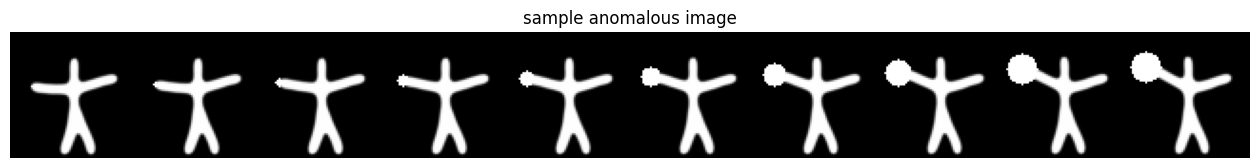

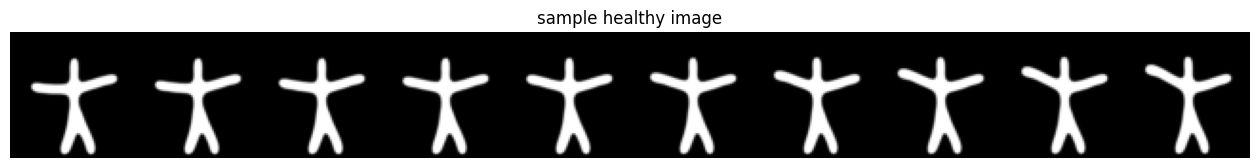

In [8]:
## Choose a sample image
i = 1
x0_ano = x_orgs[i]
x0_ht = x_hts[i]
x0_ano_gt = x_ano_gts[i]

quick_plot_tensor(x0_ano, "sample anomalous image")
quick_plot_tensor(x0_ht, "sample healthy image")

## DDIM Sample

We will test the mechanism of DDIM sample starting from a specific `start_t`, instead of starting from random noise at  `T = 1000`


### CondDDPM UAD method
https://github.com/FinnBehrendt/Conditioned-Diffusion-Models-UAD/blob/main/src/models/modules/cond_DDPM.py#L451

The method does not exactly follow DDIM sampling because: 

- When we noise the image to `start_t`, the DDIM sampling process starts predicting noise at `start_t - 1` (DDIM step)

We dont predict noise at `t = 0`. $x_0$ is obtained by:  
    - predict noise at `t = 1`
    - return `x_start`
    - use `alpha_cumprod` at t = 0 and `pred_noise` at t = 1 to produce $x_0$. 

In [ ]:
# input
b, c, h, w = 10, 1, 64, 64
shape = (b, c, h, w)
start_t = 500
sampling_timesteps = 2
x_start = x0_ano  # x0 used to generate noisy image at time t
self = gaussian_diffusion

if start_t > 0:
    total_timesteps = start_t
ddim_times = torch.linspace(0., total_timesteps, steps = sampling_timesteps + 2).int()
times = ddim_times[:-1]

times = list(reversed(times.int().tolist()))
time_pairs = list(zip(times[:-1], times[1:]))

print(f"ddim_times: {ddim_times}")
print(f"times: {times}") 

# if start_t !=0:
#     # noise the image to time start_t
#     img = gaussian_diffusion.q_sample(x_0 = x_start, t = torch.tensor([start_t],device=device), noise = noise)
# else:
#     # start from random noise
#     img = torch.randn(shape, device = device)


for time, time_next in time_pairs:
    print(f"time: {time} - time_next: {time_next}")
    # alpha = self.alphas_cumprod_prev[time]
    # alpha_next = self.alphas_cumprod_prev[time_next]

ddim_times: tensor([  0, 166, 333, 500], dtype=torch.int32)
times: [333, 166, 0]
time: 333 - time_next: 166
time: 166 - time_next: 0


### LDAE method

Currently it defaults to start at `t = T = 1000`. 

For this setting, `alpha_cumprod` ($\bar{\alpha}$) will math between DDPM and DDIM according to `timestep_map`, but `alpha_cumprod_prev` will not be cause we shift the `alpha_cumprod` to the right to add 1 at index 0, thus the new timestep_map between DDIM and DDPM should be `[0, timestep_map + 1]`. But we dont care about this details because by calculating new `beta`, we make sure that alpha_cumprod is matched, and the alpha_cumprod_prev will be shifted accordingly, because now we work with new timesteps in DDIM setting: 

    - timestep t (DDIM) -> timestep_map t_map (DDPM)
    - timestep t - 1 (DDIM) -> timestep_map t_map -1 (DDPM).
    -> alphacumprod_prev (DDIM) should be the previous step t - 1.

In [ ]:
# Input
ddim_style = "ddim10"  # 100 step DDIM
self = gaussian_diffusion


new_betas, timestep_map = self.get_ddim_betas_and_timestep_map(ddim_style, self.alphas_cumprod.cpu().numpy())
print(new_betas)
print(timestep_map)  # always start at 0 and end at T
ddim = DDIM(new_betas, timestep_map, self.device)

print(f"DDIM timestep: {ddim.timesteps}")
ddim.timestep_map

for i in reversed(range(0 + 1, ddim.timesteps + 1)):
    t_transform = ddim.t_transform(i)
    print(f"step: {i:03} - t_transform (mapped to DDPM): {t_transform}")

# Extract coef at t
test_t = 1
t = torch.full((x0_ano.shape[0],), test_t, device=ddim.device, dtype=torch.long)
t
alpha_bar_prev = ddim.extract_coef_at_t(ddim.alphas_cumprod_prev, t, x0_ano.shape)
print(f"ddim alpha_bar_prev: {alpha_bar_prev.squeeze()}")

t_map = ddim.t_transform(t)
t_map
alpha_bar_prev_ddpm = gaussian_diffusion.extract_coef_at_t(gaussian_diffusion.alphas_cumprod_prev, t_map, x0_ano.shape)
print(f"ddpm alpha_bar_prev: {alpha_bar_prev_ddpm.squeeze()}")


[1.00016594e-04 1.02892160e-01 2.65300810e-01 3.98487687e-01
 5.07727742e-01 5.97290933e-01 6.70692205e-01 7.30823994e-01
 7.80065298e-01 8.20372164e-01 8.53352368e-01]
tensor([  0,  99, 199, 299, 399, 499, 599, 699, 799, 899, 999])
DDIM timestep: 10
step: 010 - t_transform (mapped to DDPM): 999
step: 009 - t_transform (mapped to DDPM): 899
step: 008 - t_transform (mapped to DDPM): 799
step: 007 - t_transform (mapped to DDPM): 699
step: 006 - t_transform (mapped to DDPM): 599
step: 005 - t_transform (mapped to DDPM): 499
step: 004 - t_transform (mapped to DDPM): 399
step: 003 - t_transform (mapped to DDPM): 299
step: 002 - t_transform (mapped to DDPM): 199
step: 001 - t_transform (mapped to DDPM): 99
ddim alpha_bar_prev: tensor([0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999])
ddpm alpha_bar_prev: tensor([0.8989, 0.8989, 0.8989, 0.8989, 0.8989, 0.8989, 0.8989, 0.8989, 0.8989,
        0.8989])


In [162]:
ddim_alpha_cumprod = ddim.alphas_cumprod
np.append(1., ddim_alpha_cumprod[:-1])
ddim_alpha_cumprod_prev = ddim.alphas_cumprod_prev

step = 3
a = ddim.alphas_cumprod_prev[step]
a
ddim.timestep_map[step-1]


tensor(199)

In [163]:
ddpm_alpha_cumprod = gaussian_diffusion.alphas_cumprod
ddpm_alpha_cumprod_prev = gaussian_diffusion.alphas_cumprod_prev
ddpm_index = torch.nonzero(ddpm_alpha_cumprod_prev == a, as_tuple=False)
ddpm_index

tensor([[200]])

In [161]:
# Modify the timestep_maps to be able to sample from start_t
start_t = 100
ddim_style = "ddim10"

new_betas, timestep_map = self.get_ddim_betas_and_timestep_map(ddim_style, self.alphas_cumprod.cpu().numpy()[:start_t])

ddim_new = DDIM(new_betas, timestep_map, device=self.device)
print(f"ddin new timestep_map, start at {start_t}: {ddim_new.timestep_map}")
ddim_new.timesteps

print(ddim_new.alphas_cumprod)

# Check with ddpm
print(gaussian_diffusion.alphas_cumprod[ddim_new.timestep_map])

ddin new timestep_map, start at 100: tensor([ 0,  9, 19, 29, 39, 49, 59, 69, 79, 89, 99])
tensor([0.9999, 0.9981, 0.9942, 0.9884, 0.9806, 0.9710, 0.9596, 0.9464, 0.9315,
        0.9150, 0.8970])
tensor([0.9999, 0.9981, 0.9942, 0.9884, 0.9806, 0.9710, 0.9596, 0.9464, 0.9315,
        0.9150, 0.8970])


## Semantic encoder

We add noise to a certain `noise_level` and DDIM sample from this noise. 

Note: when set `noise_level`:

- The q_sample method will add noise at this exact `noise_level`. 

- But DDIM sample will also start denoise at `noise_level - 1`.

In [229]:
# Example 

noise_level = 500
ddim_style = "ddim100"  # exact equal to DDPM step. 

new_betas, timestep_map = gaussian_diffusion.get_ddim_betas_and_timestep_map(ddim_style, gaussian_diffusion.alphas_cumprod[:noise_level])
ddim = DDIM(new_betas, timestep_map, gaussian_diffusion.device)

ddim.timesteps
ddim.timestep_map

tqdm_sample = list(reversed(range(0 + 1, ddim.timesteps + 1)))
t = ddim.t_transform(tqdm_sample[0])
print(t)

tensor(499)


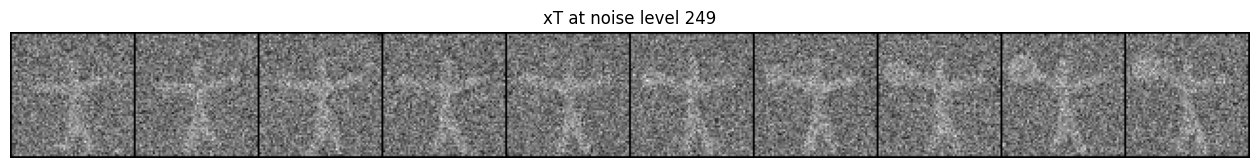

In [24]:
# Noise image to the noise_level and DDIM sample from this
noise = torch.randn_like(x0_ano)
noise_level = 250
# t = torch.full((x0_ano.shape[0],), noise_level - 1, device=device)

xT_noise = gaussian_diffusion.q_sample(x0_ano, noise_level - 1, noise)

quick_plot_tensor(xT_noise, f"xT at noise level {noise_level - 1}")

### Sample from xT

In [394]:
# DDIM sampling from starting noise_level

ddim_style = "ddim100"

x0_hat_semantic = gaussian_diffusion.representation_learning_diffae_sample(
    ddim_style=ddim_style,
    encoder=ema_encoder,
    unet=ema_decoder, 
    x_0=x0_ano,
    x_T=xT_noise,
    start_t=noise_level
)

sampling loop time step: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


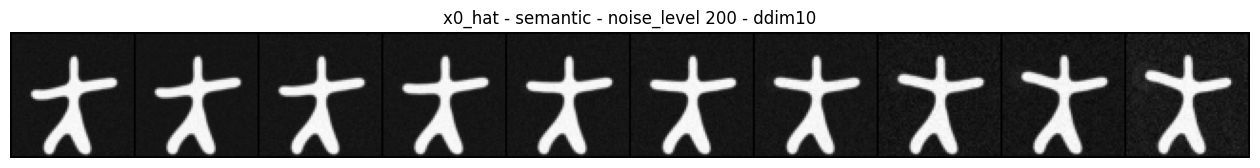

In [392]:
quick_plot_tensor(x0_hat_semantic, f"x0_hat - semantic - noise_level {noise_level} - {ddim_style}")

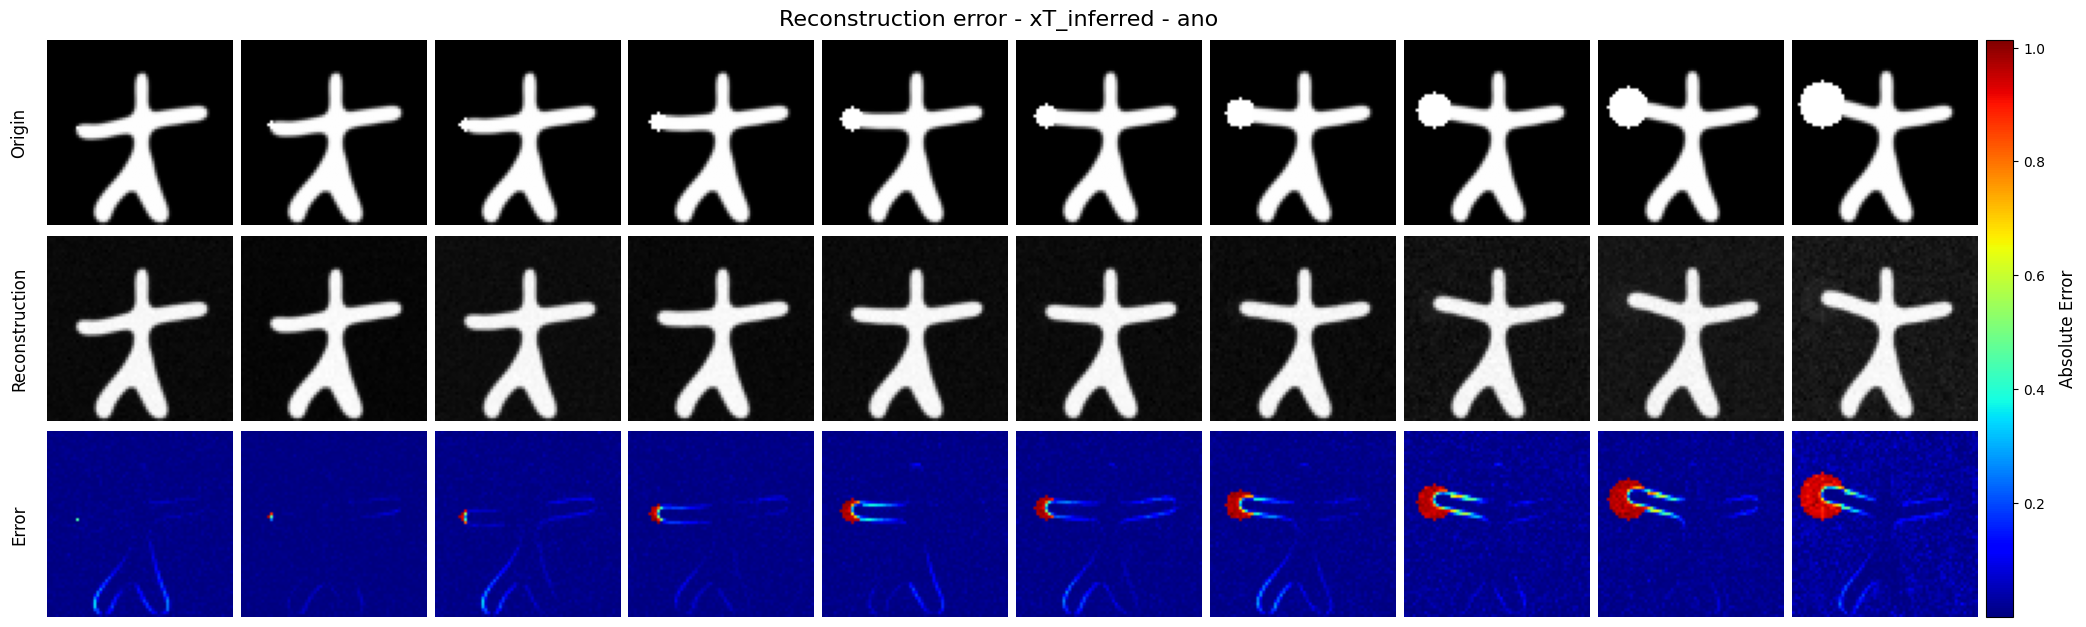

In [393]:
# Plot comparison
opt = {}
# opt["cbar_vmin"] = 0.0
# opt["cbar_vmax"] = 1.0


imgs = [
    x0_ano.detach().cpu().squeeze(), 
    x0_hat_semantic.detach().cpu().squeeze(),
    torch.abs(x0_ano - x0_hat_semantic).detach().cpu().squeeze(),
]

labels = [
    "Origin",
    "Reconstruction",
    "Error"
]

title = "Reconstruction error - xT_inferred - ano"
opt["title"] = title

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, True], opt=opt)

## Stochastic encoder

In [11]:
noise_level = 250

# Stochastic encoder
with torch.no_grad():
    out = gaussian_diffusion.representation_learning_diffae_encode(
        ddim_style="ddim50",
        encoder=ema_encoder,
        unet=ema_decoder,
        x_0=x0_ano,
        noise_level=noise_level,
        disable_tqdm=False,
        return_intermediate=True
    )



encoding loop time step: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


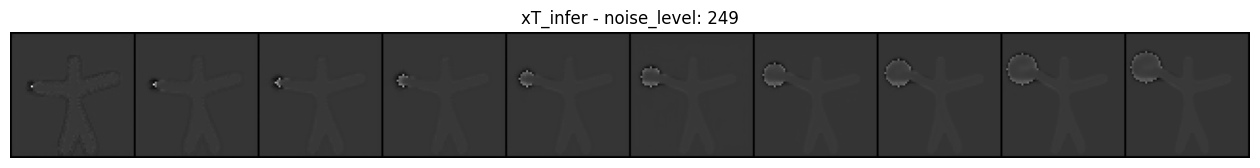

In [20]:
sample_t = out["sample_t"]
list_t = out["T"]
noise_level = out["noise_level"]
xT_infer = out["x_t"]

quick_plot_tensor(xT_infer, f"xT_infer - noise_level: {noise_level}", normalize=True)

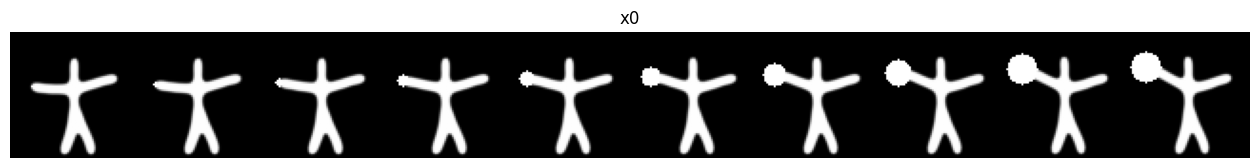

In [23]:
quick_plot_tensor(x0_ano, f"x0", normalize=True)

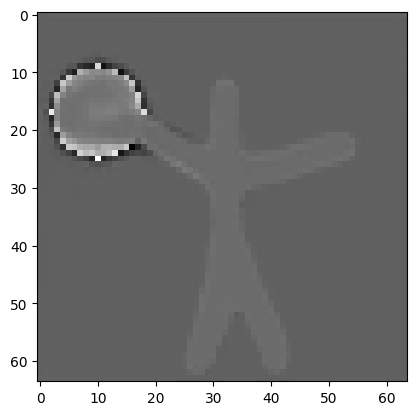

In [17]:
plt.imshow(xT_infer[9].squeeze(), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.792451..36.240887].


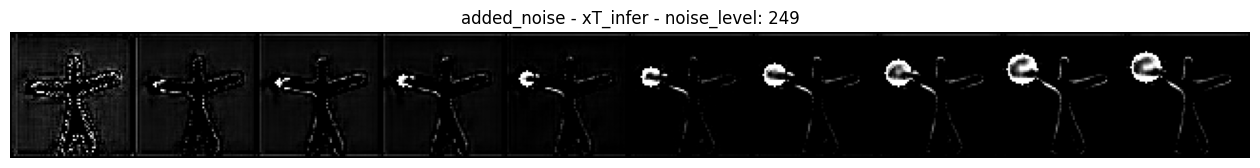

In [13]:
quick_plot_tensor(xT_infer - x0_ano, f"added_noise - xT_infer - noise_level: {noise_level}", normalize=False)

In [14]:
quick_plot_tensor(xT_noise, f"xT_noise - noise_level: {noise_level}", normalize=False)

quick_plot_tensor(xT_noise - x0_ano, f"added_noise - xT_noise - noise_level: {noise_level}", normalize=False)

NameError: name 'xT_noise' is not defined

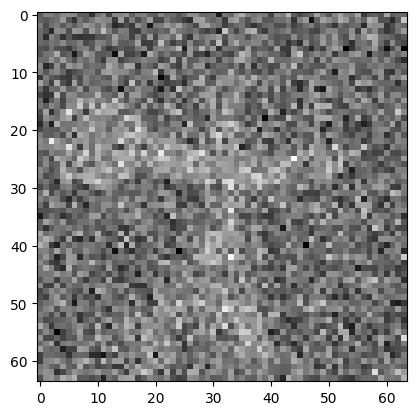

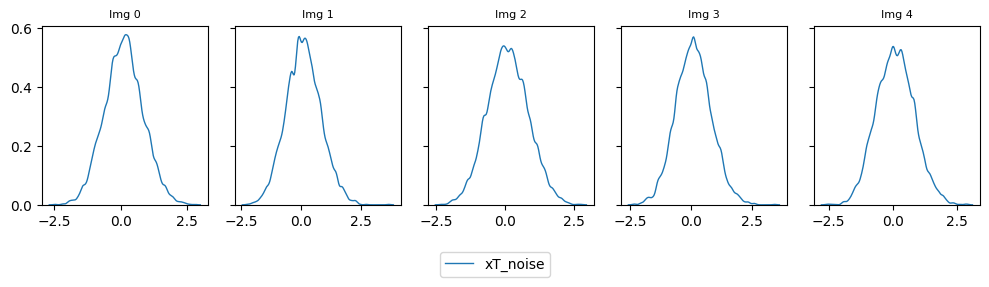

In [346]:
plt.imshow(xT_noise[9].squeeze(), cmap="gray")
plt.show()

fig = plot_kde_pixel(imgs=xT_noise.squeeze(), labels=["xT_noise"])

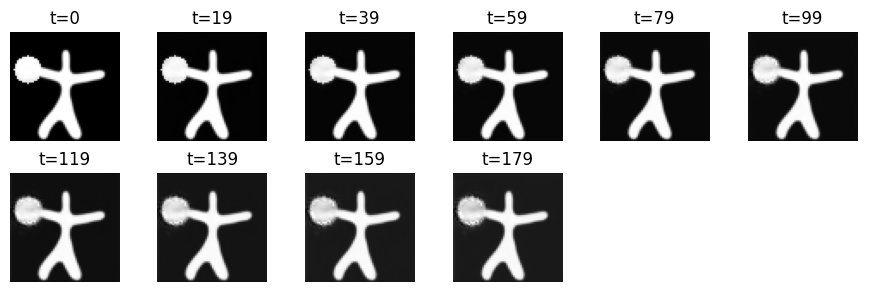

In [ ]:
img_index = 9


num_samples = len(sample_t)
cols = min(6, num_samples)
rows = (num_samples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.5 * rows))

for i, sample in enumerate(out["pred_xstart"]):
    ax = axes.flat[i]
    img = sample[img_index].squeeze()
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"t={list_t[i]}")

# Hide unused subplots
for j in range(i + 1, len(axes.flat)):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()


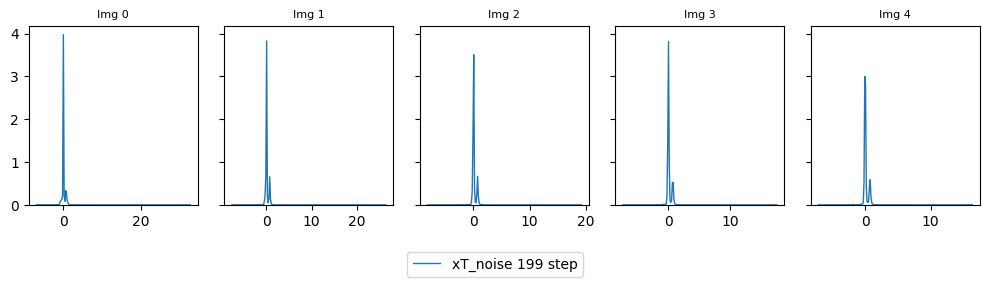

In [300]:
fig = plot_kde_pixel(
    imgs=[xT_infer], 
    labels=[f"xT_noise {noise_level} step", f"xT_infer {noise_level} step"])

### Decode from xT_infer


sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


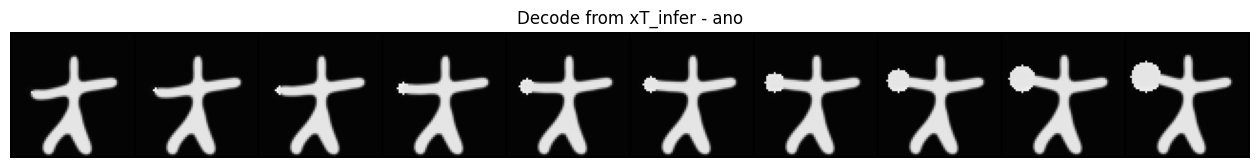

In [382]:
with torch.no_grad():
    x0_hat = gaussian_diffusion.representation_learning_diffae_sample(
        ddim_style="ddim10",
        encoder=ema_encoder,
        unet=ema_decoder,
        x_0=x0_ano,
        x_T=xT_infer,
        disable_tqdm=False,
        start_t=noise_level
    )

quick_plot_tensor(x0_hat, title="Decode from xT_infer - ano")

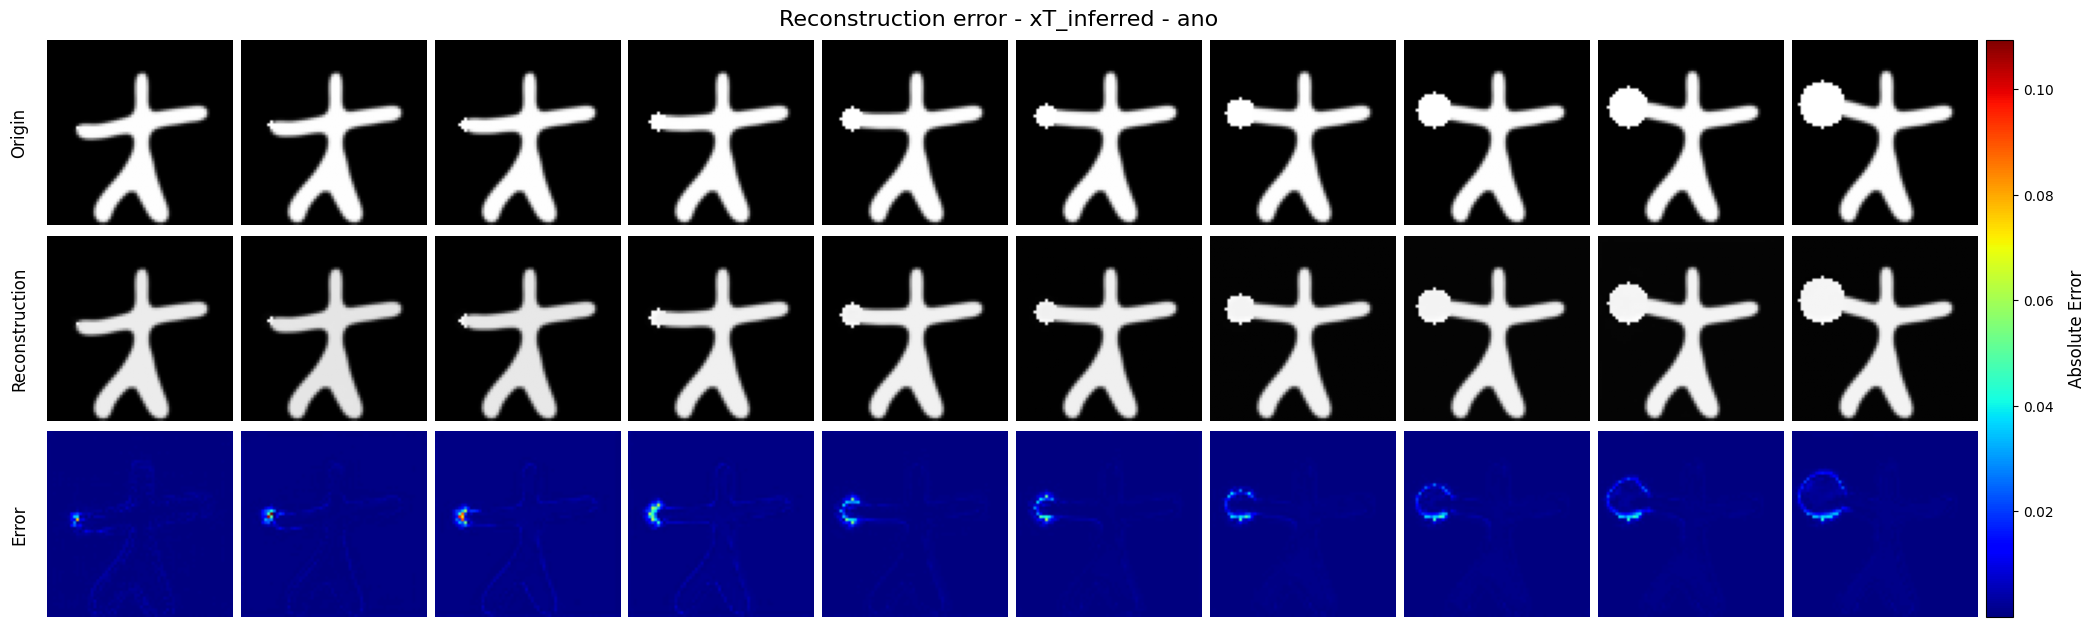

In [383]:
# Plot comparison
opt = {}
# opt["cbar_vmin"] = 0.0
# opt["cbar_vmax"] = 1.0


imgs = [
    x0_ano.detach().cpu().squeeze(), 
    x0_hat.detach().cpu().squeeze(),
    torch.abs(x0_ano - x0_hat).detach().cpu().squeeze(),
]

labels = [
    "Origin",
    "Reconstruction",
    "Error"
]

title = "Reconstruction error - xT_inferred - ano"
opt["title"] = title

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, True], opt=opt)

# Image interpolation


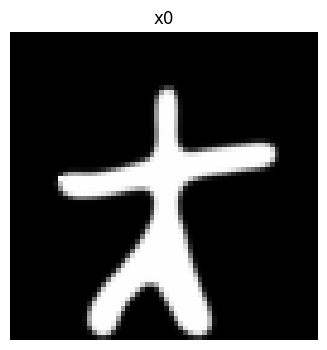

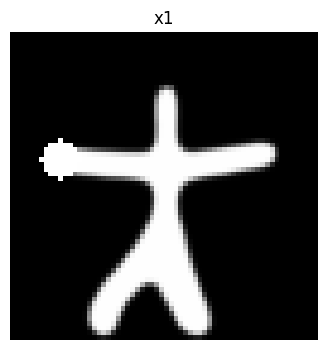

In [404]:
# Select image from different timeframe of the same patient

x0 = x0_ano[[0]]
x1 = x0_ano[[5]]

quick_plot_tensor(x0, "x0")

quick_plot_tensor(x1, "x1")

## lerp-slerp mode

In [ ]:
alpha = np.linspace(0., 1., 10)
x_interpolated = []
zT = []
ddim_style = "ddim10"


for a in alpha: 
    print(f"Start interpolation with alpha = {a}")
    out = gaussian_diffusion.lerp_slerp_interpolation(
            ddim_encode=ddim_style,
            ddim_decode=ddim_style,
            encoder=ema_encoder,
            decoder=ema_decoder,
            x_0=x0,
            x_1=x1,
            z_0=None,
            z_1=None,
            alpha=a,
            disable_tqdm=False,
            noise_level=100
        )
    x_interpolated.append(out["x"].squeeze())
    zT.append(out["z_T"].squeeze())

Start interpolation with alpha = 0.0


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.74it/s]


Start interpolation with alpha = 0.1111111111111111


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 20.20it/s]


Start interpolation with alpha = 0.2222222222222222


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 17.95it/s]


Start interpolation with alpha = 0.3333333333333333


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 20.30it/s]


Start interpolation with alpha = 0.4444444444444444


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s]


Start interpolation with alpha = 0.5555555555555556


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


Start interpolation with alpha = 0.6666666666666666


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 19.49it/s]


Start interpolation with alpha = 0.7777777777777777


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 22.57it/s]


Start interpolation with alpha = 0.8888888888888888


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.38it/s]


Start interpolation with alpha = 1.0


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 21.13it/s]


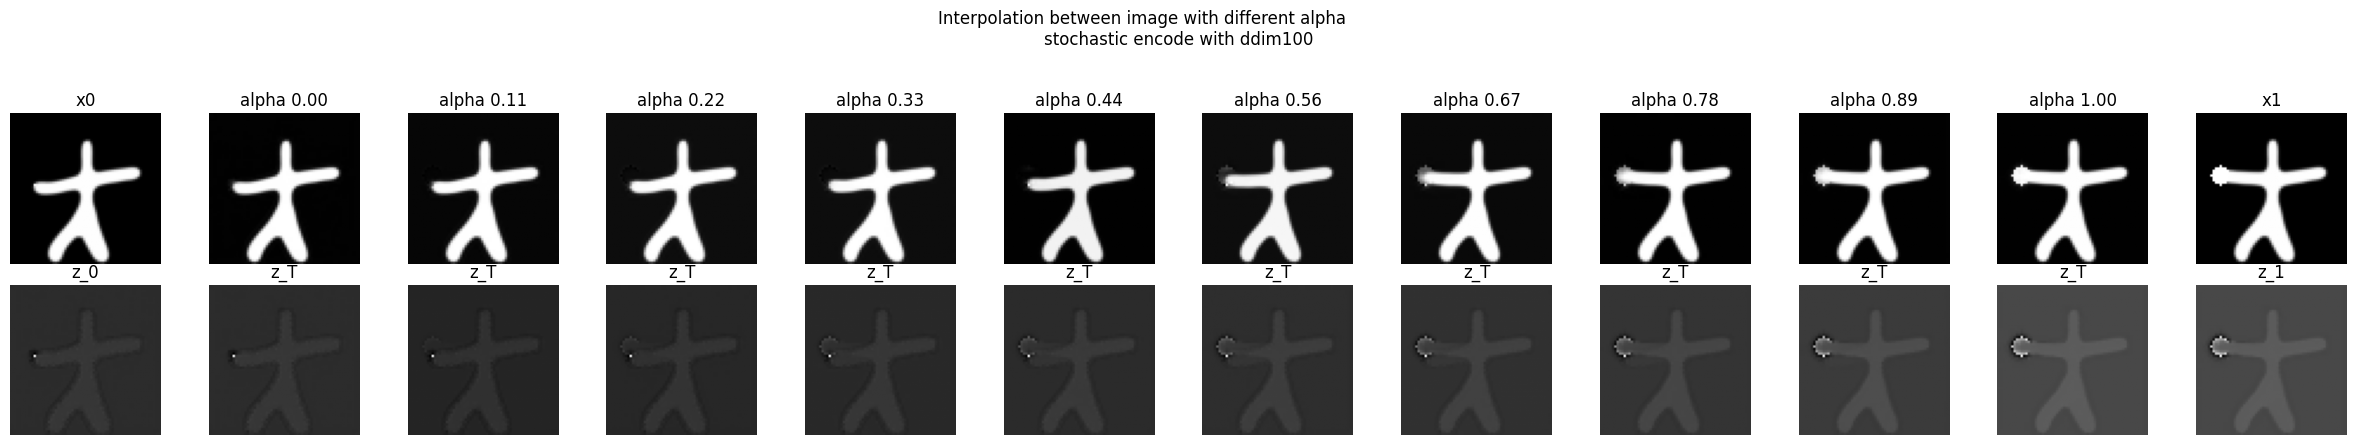

In [438]:
ncol = len(x_interpolated) + 2
nrow = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(2. * ncol, 2.1 *nrow))

# x0 image
ax = axes[0, 0]
ax.imshow(x0.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x0")

ax = axes[1, 0]
ax.imshow(out["z_0"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_0")

# x1 image
ax = axes[0, -1]
ax.imshow(x1.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x1")

ax = axes[1, -1]
ax.imshow(out["z_1"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_1")

# interpolation image
for i, img in enumerate(x_interpolated):
    
    ax = axes[0, i+1]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"alpha {alpha[i]:.2f}")

    ax = axes[1, i+1]
    ax.imshow(zT[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"z_T")

plt.suptitle(f"Interpolation between image with different alpha \
             \nstochastic encode with {ddim_style}", y=1.05)
plt.tight_layout()
plt.show()

## lerp-lerp mode

In [440]:
alpha = np.linspace(0., 1., 10)
x_interpolated = []
zT = []
ddim_style = "ddim10"


for a in alpha: 
    print(f"Start interpolation with alpha = {a}")
    out = gaussian_diffusion.lerp_slerp_interpolation(
            ddim_encode=ddim_style,
            ddim_decode=ddim_style,
            encoder=ema_encoder,
            decoder=ema_decoder,
            x_0=x0,
            x_1=x1,
            z_0=None,
            z_1=None,
            alpha=a,
            disable_tqdm=False,
            noise_level=100,
            mode=["lerp", "lerp"]
        )
    x_interpolated.append(out["x"].squeeze())
    zT.append(out["z_T"].squeeze())

Start interpolation with alpha = 0.0


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s]


Start interpolation with alpha = 0.1111111111111111


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.58it/s]


Start interpolation with alpha = 0.2222222222222222


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


Start interpolation with alpha = 0.3333333333333333


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s]


Start interpolation with alpha = 0.4444444444444444


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.22it/s]


Start interpolation with alpha = 0.5555555555555556


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s]


Start interpolation with alpha = 0.6666666666666666


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.94it/s]


Start interpolation with alpha = 0.7777777777777777


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s]


Start interpolation with alpha = 0.8888888888888888


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s]


Start interpolation with alpha = 1.0


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s]


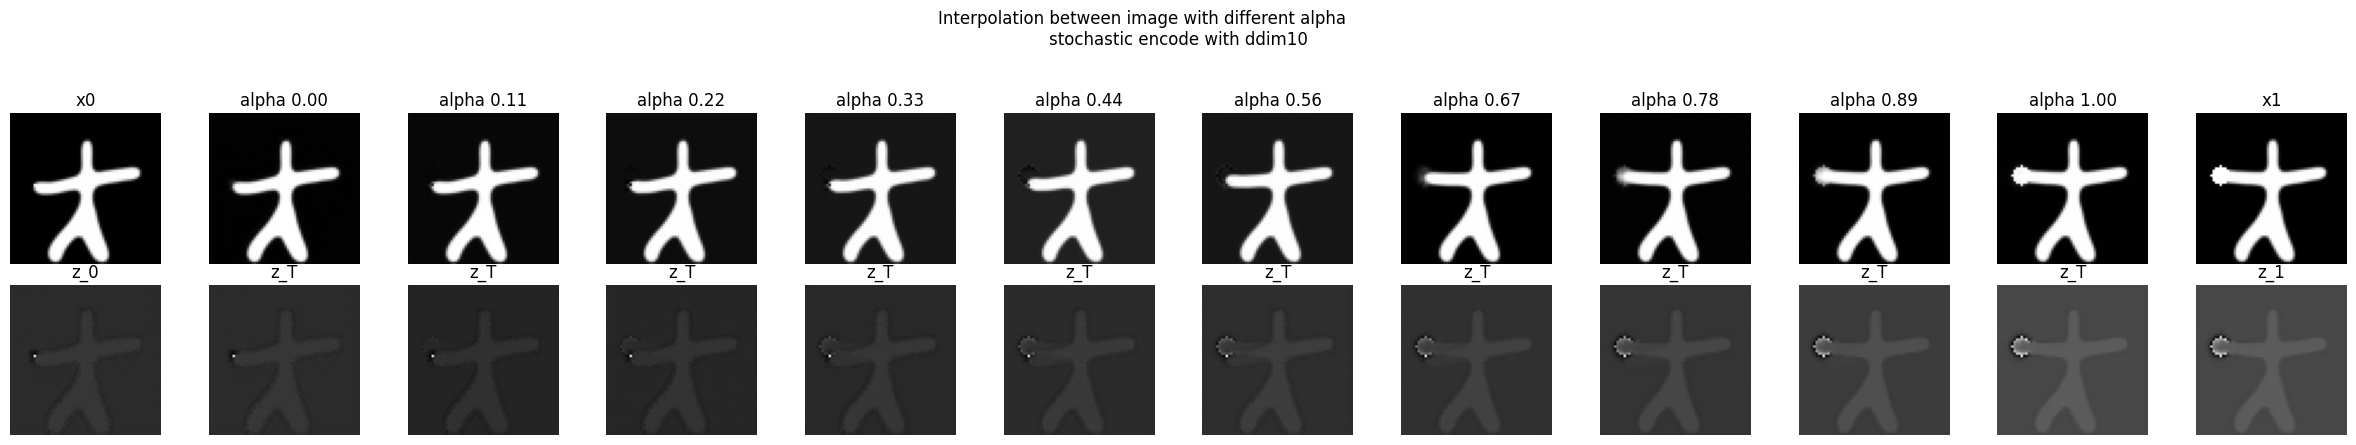

In [441]:
ncol = len(x_interpolated) + 2
nrow = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(2. * ncol, 2.1 *nrow))

# x0 image
ax = axes[0, 0]
ax.imshow(x0.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x0")

ax = axes[1, 0]
ax.imshow(out["z_0"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_0")

# x1 image
ax = axes[0, -1]
ax.imshow(x1.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x1")

ax = axes[1, -1]
ax.imshow(out["z_1"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_1")

# interpolation image
for i, img in enumerate(x_interpolated):
    
    ax = axes[0, i+1]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"alpha {alpha[i]:.2f}")

    ax = axes[1, i+1]
    ax.imshow(zT[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"z_T")

plt.suptitle(f"Interpolation between image with different alpha \
             \nstochastic encode with {ddim_style}", y=1.05)
plt.tight_layout()
plt.show()

# Trajectory interpolation